In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


sns.set(style="darkgrid") # Plot parameters defined globally
plt.style.use("seaborn-v0_8-dark")     

# Part 2: Data Preparation 
----
----

---
## CH4: Load and Explore time-series Data
---

In [2]:
df = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True)

In [3]:
df.head()

Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44

This dataset describes the number of daily female births in California in 1959. The units are a count and there are 365 observations. 

Since we have one column, we turn the dataframe to a Series object by ["squeezing"](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html) the columns 

In [4]:
series = df.squeeze('columns')
print(type(series))

<class 'pandas.core.series.Series'>


In [5]:
series.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

In [6]:
series.size # length of the series data 

# len(series) alternative

365

In [7]:
series['1959-01'][:5] # query by the year and month and show the first 5 entries

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

In [8]:
series.describe()

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: Births, dtype: float64

----
## CH5: Basic Feature Engineering
----

### Potential feature we can look at when we deal with a Time-series data 

- Date Time features: these are components (day of the month, month of the year etc) of the time step itself

- Lag Features: these are actually target values of prior time steps 

- Window Features: these are a summary of values over a fixed window of prior time 

In [9]:
dt_df = pd.read_csv('daily-min-temperatures.csv', index_col = 0, header = 0, parse_dates=True)
dt_series = dt_df.squeeze('columns') # series object out of data frame 

dt_df.head()

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

### Date Time Features

In [10]:
# Lets engineer features using the data time index of the series object to get day of the month and month of the year features  

dt_df['day'] = [dt_series.index[i].day for i in range(len(dt_series))]
dt_df['month'] = [dt_series.index[i].month for i in range(len(dt_series))]
dt_df['temperature'] = [dt_series[i] for i in range(len(dt_series))]

dt_df.drop(columns='Temp', inplace=True)

dt_df.head()

day  month  temperature
Date                               
1981-01-01    1      1         20.7
1981-01-02    2      1         17.9
1981-01-03    3      1         18.8
1981-01-04    4      1         14.6
1981-01-05    5      1         15.8

In [ ]:
# For this data set we can also consider the season = Winter, Spring, Summer, Autmn as a good predictor value 

### Lagged Features

In [11]:
temps = pd.DataFrame(dt_series.values)

lag_dt_df = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis = 1)

lag_dt_df.columns = ['t-2', 't-1', 't', 't+1']

lag_dt_df.head()

t-2   t-1     t   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8

In real application the deal is to find the suitable window of lagged variables that increase the model performance. After a certain threshold, the returns from the model performance is expected to diminish using lagged features. For the temperature dataset above, we can also consider lagged variables with a larger window, e.g temperature from the last week / year at the same day 

### Features from Rolling window Statistics 

In [12]:
shifted = temps.shift(1)

window = shifted.rolling(window = 2)

means = window.mean()

window_df = pd.concat([means, temps], axis = 1)

window_df.columns = ['mean(t,t-1)', 't+1']

window_df.head()

mean(t,t-1)   t+1
0          NaN  20.7
1          NaN  17.9
2        19.30  18.8
3        18.35  14.6
4        16.70  15.8

There are more statistics we can calculate and even different mathematical ways of calculating the definition of the window. Below is another example that shows a window width of 3 and a dataset comprised of more summary statistics, specifically the minimum, mean, and maximum value in the window.
You can see in the code that we are explicitly specifying the sliding window width as a named variable. This allows us to use it both in calculating the correct shift of the series and in specifying the width of the window to the rolling() function.

In [13]:
# create more rolling statistics to generate more features 

width = 3 #the width of window statistics 

shifted = temps.shift(width - 1)

window = shifted.rolling(window = width)

means = window.mean()

mins = window.min()

maxs = window.max()

window_dfa = pd.concat([mins, means, maxs, temps],axis = 1)

window_dfa.columns = ['min', 'mean', 'max', 't+1']

window_dfa.head()



min       mean   max   t+1
0   NaN        NaN   NaN  20.7
1   NaN        NaN   NaN  17.9
2   NaN        NaN   NaN  18.8
3   NaN        NaN   NaN  14.6
4  17.9  19.133333  20.7  15.8

### Expanding Window Statistics 

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data. Like the rolling() function on DataFrame, Pandas provides an expanding() function that collects sets of all prior values for each time step.

In [14]:
window = temps.expanding()
dataframe = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
dataframe.head(5)

min       mean   max   t+1
0  20.7  20.700000  20.7  17.9
1  17.9  19.300000  20.7  18.8
2  17.9  19.133333  20.7  14.6
3  14.6  18.000000  20.7  15.8
4  14.6  17.560000  20.7  15.8

----
## CH6: Data Visualization
----


Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model. In this tutorial, you will discover 6 different types of plots that you can use to visualize time series data with Python. Specifically, after completing this tutorial, you will know:
- How to explore the temporal structure of time series with line plots, lag plots, and autocorrelation plots.
- How to understand the distribution of observations using histograms and density plots.
- How to tease out the change in distribution over intervals using box and whisker plots and heat map plots.

### Line Plots

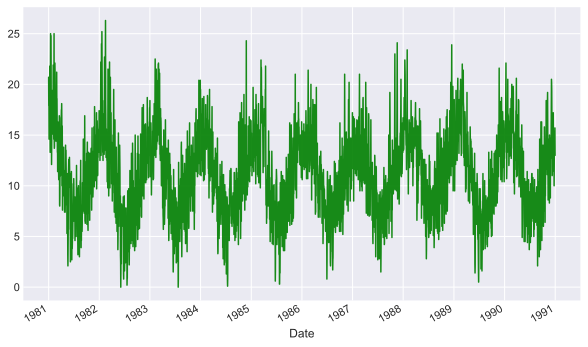

In [15]:
fig = plt.subplots(figsize = (10,6))

dt_series.plot(color = 'green', alpha = 0.9)

plt.grid()
plt.show()

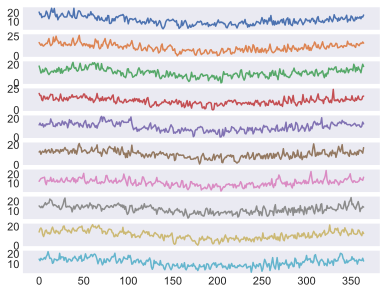

In [41]:
# Group annually and make a stacked line plot for each year in the data

groups = dt_series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  
  years[name.year] = group.values
years.plot(subplots=True, legend=False)

plt.show()

### Histograms and Density Plots

Another important visualization is of the distribution of observations themselves. This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.

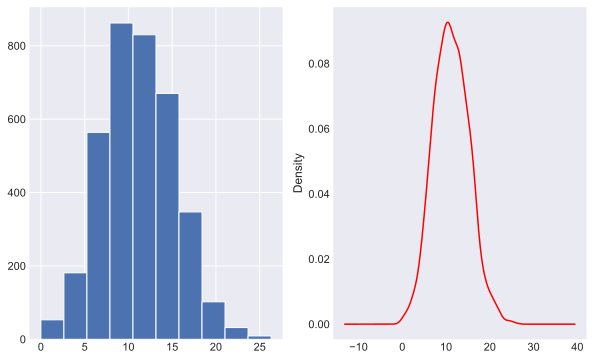

In [16]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize = (10,6), sharey=False)

dt_series.hist(bins=10, ax = axes[0])
dt_series.plot(kind = 'kde', color = 'red', ax = axes[1])

plt.show()

We can see that perhaps the distribution is a little asymmetrical and perhaps a little pointy to be Gaussian. Seeing a distribution like this may suggest later exploring statistical hypothesis tests to formally check if the distribution is Gaussian and perhaps data preparation techniques to reshape the distribution, like the Box-Cox transform.

### Box and Whisker Plots by Interval

Histograms and density plots provide insight into the distribution of all observations, but we may be interested in the distribution of values by time interval. Another type of plot that is useful to summarize the distribution of observations is the box and whisker plot. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.

Box and whisker plots can be created and compared for each interval in a time series, such as years, months, or days. Below is an example of grouping the Minimum Daily Temperatures dataset by years, as was done above in the plot example. A box and whisker plot is then created for each year and lined up side-by-side for direct comparison.

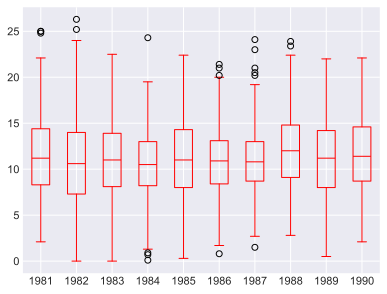

In [17]:
groups = dt_series.groupby(pd.Grouper(freq='A'))

years = pd.DataFrame()

for name, group in groups:
  
  years[name.year] = group.values
years.boxplot(color = 'red')
plt.show()

We may also be interested in the distribution of values across months within a year. The example below creates 12 box and whisker plots, one for each month of 1990, the last year in the dataset. In the example, first, only observations from 1990 are extracted. Then, the observations are grouped by month, and each month is added to a new DataFrame as a column. Finally, a box and whisker plot is created for each month-column in the newly constructed DataFrame.

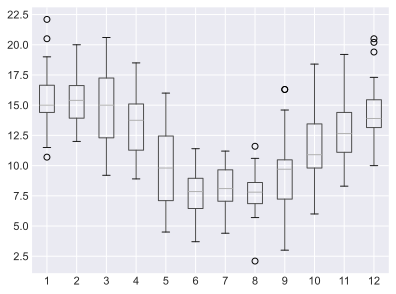

In [18]:
one_year = dt_series['1990']
monthly_groups = one_year.groupby(pd.Grouper(freq = 'M'))

months = pd.concat([pd.DataFrame(m[1].values) for m in monthly_groups], axis = 1)

months = pd.DataFrame(months)

months.columns = range(1,13)

months.boxplot()

plt.show()

Running the example creates 12 box and whisker plots, showing the significant change in distribution of minimum temperatures across the months of the year from the Southern Hemisphere summer in January to the Southern Hemisphere winter in the middle of the year, and back to summer again.

### Heat Maps

A matrix of numbers can be plotted as a surface, where the values in each cell of the matrix are assigned a unique color. This is called a heatmap, as larger values can be drawn with warmer colors (yellows and reds) and smaller values can be drawn with cooler colors (blues and greens). Like the box and whisker plots, we can compare observations between intervals using a heat map.
In the case of the Minimum Daily Temperatures, the observations can be arranged into a matrix of year-columns and day-rows, with minimum temperature in the cell for each day. We can also arrange a matrix of months within a year vs minimum temperature. A heat map of this matrix can then be plotted. Below is an example of creating a heatmap of the Minimum Daily Temperatures data. The matshow() function from the Matplotlib library is used as no heatmap support is provided directly in Pandas.

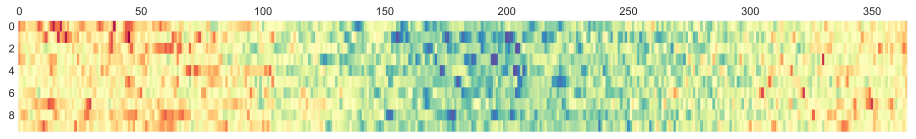

In [19]:
plt.matshow(years.T, interpolation=None, cmap = 'Spectral_r', aspect='auto')

plt.show()

The plot shows the cooler minimum temperatures in the middle days of the years and the warmer minimum temperatures in the start and ends of the years, and all the fading and complexity in between.

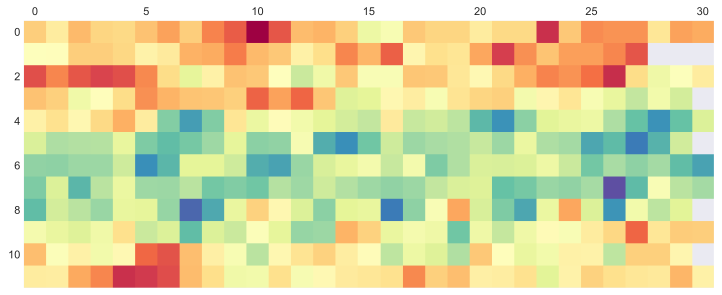

In [20]:
plt.matshow(months.T, interpolation=None, cmap = 'Spectral_r', aspect='auto')

plt.show()

Running the example shows the same macro trend seen for each year on the zoomed level of month-to-month. We can also see some white patches at the bottom of the plot. This is missing data for those months that have fewer than 31 days, with February being quite an outlier with
28 days in 1990.

### Lag Scatter Plots

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the `lag_plot`. It plots the observation at time t on the x-axis and the observation at the next time step (t+1) on the y-axis.

- If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
- If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
- Either relationship is good as they can be modeled.
More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship. Below is an example of a lag plot for the Minimum Daily Temperatures dataset.

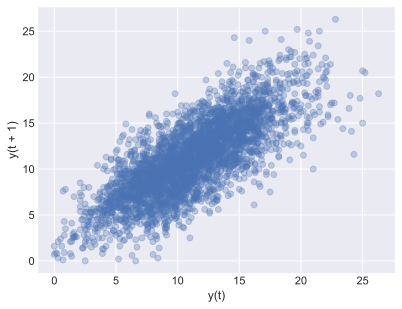

In [21]:
from pandas.plotting import lag_plot

lag_plot(dt_series, alpha = 0.3)

plt.grid()
plt.show()

We can look at multiple Lag plots to see how the current observation is correlated with the previous 7 days

In [22]:
values = pd.DataFrame(dt_series.values)

In [23]:
# data frame with all observations and their lagged values 

lags = 7
columns = [values]
for i in range(1,(lags + 1)):
  columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)

In [24]:
dataframe.tail()

0     0     0     0     0     0     0     0
3645  14.0  14.6  12.9  10.0  13.9  13.2  13.1  15.4
3646  13.6  14.0  14.6  12.9  10.0  13.9  13.2  13.1
3647  13.5  13.6  14.0  14.6  12.9  10.0  13.9  13.2
3648  15.7  13.5  13.6  14.0  14.6  12.9  10.0  13.9
3649  13.0  15.7  13.5  13.6  14.0  14.6  12.9  10.0

In [25]:
# naming the columns of the dataframe above from t to t-7

column_names = ['t']

for i in range(1,(lags + 1)):
    
    column_names.append(f"t-{i}")

dataframe.columns = column_names

In [26]:
dataframe.head()

t   t-1   t-2   t-3   t-4  t-5  t-6  t-7
0  20.7   NaN   NaN   NaN   NaN  NaN  NaN  NaN
1  17.9  20.7   NaN   NaN   NaN  NaN  NaN  NaN
2  18.8  17.9  20.7   NaN   NaN  NaN  NaN  NaN
3  14.6  18.8  17.9  20.7   NaN  NaN  NaN  NaN
4  15.8  14.6  18.8  17.9  20.7  NaN  NaN  NaN

In [27]:
plt.figure(figsize=(6,10))
plt.subplots_adjust(hspace=0.5)

for i in range(1,(lags + 1)):
    
    axes = plt.subplot(3,3,i)

    axes.scatter(x=dataframe['t'].values, y=dataframe[f't-{i}'].values, alpha = 0.4)

    axes.set_title(f"t vs t-{i}")

plt.show()

### Autocorrelation Plots

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.
Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot and Pandas provides this capability built in, called the `autocorrelation plot()` function.

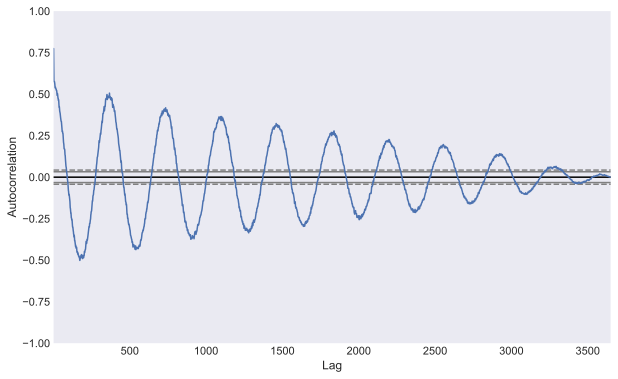

In [28]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,6))

autocorrelation_plot(dt_series)

plt.grid()
plt.show()


- The horizontal lines in the plot correspond to 95% and 99% confidence bands.

- The dashed line is 99% confidence band.

----

## CH7: Resampling and Interpolation

----

You may have observations at the wrong frequency. Maybe they are too granular or not granular enough. The Pandas library in Python provides the capability to change the frequency of your time series data. In this tutorial, you will discover how to use Pandas in Python to both increase and decrease the sampling frequency of time series data. After completing this tutorial, you will know:

- About time series resampling, the two types of resampling, and the 2 main reasons why you need to use them.
- How to use Pandas to upsample time series data to a higher frequency and interpolate the new observations.
- How to use Pandas to downsample time series data to a lower frequency and summarize the higher frequency observations.

### Resampling

Resampling involves changing the frequency of your time series observations. Two types of resampling are:
- **Upsampling:** Where you increase the frequency of the samples, such as from minutes to seconds.
- **Downsampling:** Where you decrease the frequency of the samples, such as from days to months.

In both cases, data must be invented. In the case of upsampling, care may be needed in determining how the fine-grained observations are calculated using interpolation. In the case of downsampling, care may be needed in selecting the summary statistics used to calculate the new aggregated values.
There are perhaps two main reasons why you may be interested in resampling your time series data:

- **Problem Framing:** Resampling may be required if your data is not available at the
same frequency that you want to make predictions.
- **Feature Engineering:** Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.

There is a lot of overlap between these two cases. For example, you may have daily data and want to predict a monthly problem. You could use the daily data directly or you could downsample it to monthly data and develop your model. A feature engineering perspective may use observations and summaries of observations from both time scales and more in developing a model.

We will use the Shampoo Sales dataset as an example. This dataset describes the monthly number of sales of shampoo over a 3 year period. 

In [29]:
ss_df = pd.read_csv('monthly-shampoo-sales.csv', index_col = 0, header = 0, parse_dates=True)

ss_df.head()

Sales
Month       
1-01   266.0
1-02   145.9
1-03   183.1
1-04   119.3
1-05   180.3

### Up-sampling

In [30]:
# Data does not have year values. A custom function is used to parse the dates and baseline the year number on an arbitrary year (1901)
# so that the date-times can be be interpreted correctly in the Pandas Series.

from datetime import datetime # pandas.datetime will be deprecated 

def custom_parser(x):

    return datetime.strptime("190" + x, '%Y-%m')

ss_df = pd.read_csv('monthly-shampoo-sales.csv', index_col = 0, header = 0, parse_dates=True, date_parser = custom_parser)

ss_df.head()

Sales
Month            
1901-01-01  266.0
1901-02-01  145.9
1901-03-01  183.1
1901-04-01  119.3
1901-05-01  180.3

In [31]:
ss_series = ss_df.squeeze('columns')

In [32]:
# upsampling 

upsamp_ss_series = ss_series.resample('D').mean()

upsamp_ss_series.head(32)

Month
1901-01-01    266.0
1901-01-02      NaN
1901-01-03      NaN
1901-01-04      NaN
1901-01-05      NaN
1901-01-06      NaN
1901-01-07      NaN
1901-01-08      NaN
1901-01-09      NaN
1901-01-10      NaN
1901-01-11      NaN
1901-01-12      NaN
1901-01-13      NaN
1901-01-14      NaN
1901-01-15      NaN
1901-01-16      NaN
1901-01-17      NaN
1901-01-18      NaN
1901-01-19      NaN
1901-01-20      NaN
1901-01-21      NaN
1901-01-22      NaN
1901-01-23      NaN
1901-01-24      NaN
1901-01-25      NaN
1901-01-26      NaN
1901-01-27      NaN
1901-01-28      NaN
1901-01-29      NaN
1901-01-30      NaN
1901-01-31      NaN
1901-02-01    145.9
Freq: D, Name: Sales, dtype: float64

 Notice that resample method created days within a month with NaN values. Now, we can interpolate the missing values at this new frequency. The Series Pandas object provides an `interpolate()` function to interpolate missing values, and there is a nice selection of simple and more complex interpolation functions. You may have domain knowledge to help choose how values are to be interpolated. A good starting point is to use a linear interpolation. This draws a straight line between available data, in this case on the first of the month, and fills in values at the chosen frequency from this line.

In [33]:
int_upsamp_ss_series = upsamp_ss_series.interpolate(method = 'linear') # linear interpolation

int_upsamp_ss_series2 = upsamp_ss_series.interpolate(method = 'spline', order = 2)

int_upsamp_ss_series.head(32)

Month
1901-01-01    266.000000
1901-01-02    262.125806
1901-01-03    258.251613
1901-01-04    254.377419
1901-01-05    250.503226
1901-01-06    246.629032
1901-01-07    242.754839
1901-01-08    238.880645
1901-01-09    235.006452
1901-01-10    231.132258
1901-01-11    227.258065
1901-01-12    223.383871
1901-01-13    219.509677
1901-01-14    215.635484
1901-01-15    211.761290
1901-01-16    207.887097
1901-01-17    204.012903
1901-01-18    200.138710
1901-01-19    196.264516
1901-01-20    192.390323
1901-01-21    188.516129
1901-01-22    184.641935
1901-01-23    180.767742
1901-01-24    176.893548
1901-01-25    173.019355
1901-01-26    169.145161
1901-01-27    165.270968
1901-01-28    161.396774
1901-01-29    157.522581
1901-01-30    153.648387
1901-01-31    149.774194
1901-02-01    145.900000
Freq: D, Name: Sales, dtype: float64

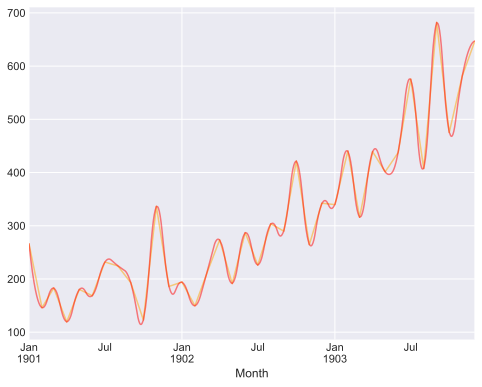

In [34]:
## Plot the interpolated series
fig, axes = plt.subplots(figsize = (8,6))


int_upsamp_ss_series.plot(color = 'orange', alpha = 0.5, ax = axes)
int_upsamp_ss_series2.plot(color = 'red', alpha = 0.5, ax = axes)
plt.grid()
plt.show()


### Down-sampling

The sales data is monthly, but perhaps we would prefer the data to be quarterly. The year can be divided into 4 business quarters, 3 months a piece. Instead of creating new rows between existing observations, the `resample()` function in Pandas will group all observations by the new frequency.

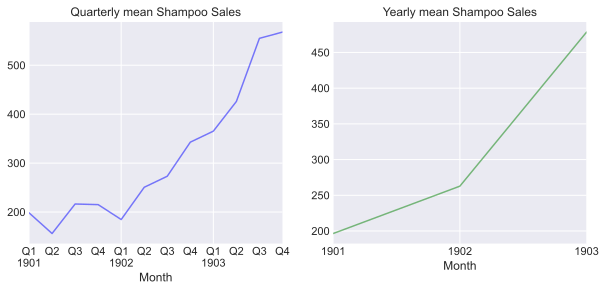

In [35]:
# Down-sampling to quarterly and yearly mean 


dsamp_ss_qseries = ss_series.resample('Q')
quarterly_ss = dsamp_ss_qseries.mean()

dsamp_ss_aseries = ss_series.resample('A')
annual_ss = dsamp_ss_aseries.mean()

fig, axes = plt.subplots(1,2,figsize = (10,4))
plt.subplots_adjust(hspace=0.5)

quarterly_ss.plot(color = 'blue', alpha = 0.5, ax = axes[0])
annual_ss.plot(color = 'green', alpha = 0.5, ax = axes[1])

axes[0].set_title('Quarterly mean Shampoo Sales')
axes[1].set_title('Yearly mean Shampoo Sales')

for i in range(2):
    axes[i].grid()

plt.show()

---

## CH8: Power Transforms

----

Data transforms are intended to remove noise and improve the signal in time series forecasting. It can be very difficult to select a good, or even best, transform for a given prediction problem. There are many transforms to choose from and each has a different mathematical intuition. In this tutorial, you will discover how to explore different power-based transforms for time series forecasting with Python. After completing this tutorial, you will know:

- How to identify when to use and how to explore a square root transform.
- How to identify when to use and explore a log transform and the expectations on raw
data.
- How to use the Box-Cox transform to perform square root, log, and automatically discover the best power transform for your dataset.


In this lesson, we will use the Airline Passengers dataset as an example. This dataset describes the total number of airline passengers over time. There are 144 monthly observations from 1949 to 1960.

In [36]:
ap_df = pd.read_csv('airline-passengers.csv', index_col=0, header = 0, parse_dates=True)

ap_df.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

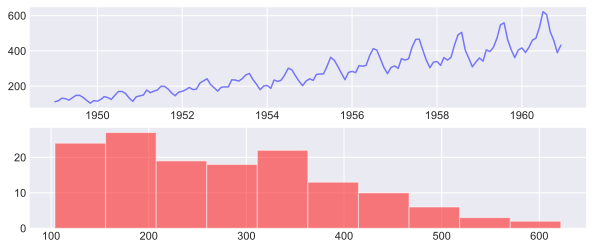

In [37]:
ap_series = ap_df.squeeze('columns')

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(ap_series, color = 'blue', alpha = 0.5)
axes[1].hist(ap_series,bins = 10, alpha = 0.5, color = 'red')

axes[0].grid()
axes[1].grid()
plt.show()

The dataset is non-stationary, meaning that the mean and the variance of the observations change over time. This makes it difficult to model by both classical statistical methods, like ARIMA, and more sophisticated machine learning methods, like neural networks. This is caused by what appears to be both an increasing trend and a seasonality component.

In addition, the amount of change, or the variance, is increasing with time. This is clear when you look at the size of the seasonal component and notice that from one cycle to the next, the amplitude (from bottom to top of the cycle) is increasing. In this tutorial, we will investigate transforms that we can use on time series datasets that exhibit this property.


### Square Root Transform

A time series that has a quadratic growth trend can be made linear by taking the square root. Let’s demonstrate this with a quick contrived example. Consider a series of the numbers 1 to 99 squared. The line plot of this series will show a quadratic growth trend and a histogram of the values will show an exponential distribution with a long tail. The snippet of code below creates and graphs this series.

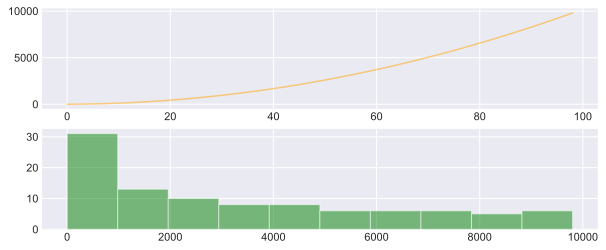

In [38]:
quad_series = [i**2 for i in range(1,100)]

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(quad_series, color = 'orange', alpha = 0.5)
axes[1].hist(quad_series,bins = 10, alpha = 0.5, color = 'green')

axes[0].grid()
axes[1].grid()
plt.show()


If you see a structure like this in your own time series, you may have a quadratic growth trend. This can be removed or made linear by taking the inverse operation of the squaring procedure, which is the square root. Because the example is perfectly quadratic, we would expect the line plot of the transformed data to show a straight line. 

Because the source of the squared series is linear, we would expect the histogram to show a uniform distribution. The
example below performs a `sqrt()` transform on the time series and plots the result.

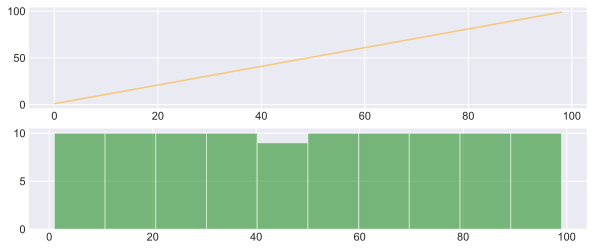

In [39]:
import numpy as np

lin_series = np.sqrt(quad_series)

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(lin_series, color = 'orange', alpha = 0.5)
axes[1].hist(lin_series,bins = 10, alpha = 0.5, color = 'green')

axes[0].grid()
axes[1].grid()
plt.show()


It is possible that the Airline Passengers dataset shows a quadratic growth. If this is the case, then we could expect a square root transform to reduce the growth trend to be linear and change the distribution of observations to be perhaps nearly Gaussian. The example below
performs a square root of the dataset and plots the results.

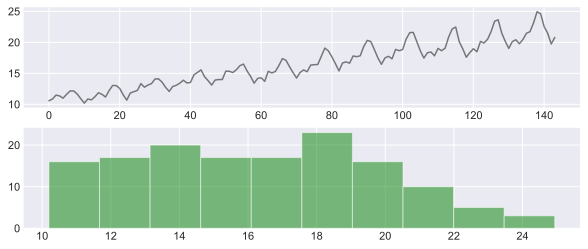

In [40]:
pass_df = pd.DataFrame(ap_series.values)

pass_df.columns = ['passangers']

pass_df.passangers = np.sqrt(pass_df['passangers'])

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(pass_df.passangers, color = 'black', alpha = 0.5)
axes[1].hist(pass_df.passangers,bins = 10, alpha = 0.5, color = 'green')

axes[0].grid()
axes[1].grid()
plt.show()



We can see that the trend was reduced, but was not removed. The line plot still shows an increasing variance from cycle to cycle. The histogram still shows a long tail to the right of the distribution, suggesting an exponential or long-tail distribution.

### Log Transform

A class of more extreme trends are exponential, often graphed as a hockey stick. Time series with an exponential distribution can be made linear by taking the logarithm of the values. This is called a log transform. As with the square and square root case above, we can demonstrate this with a quick example.

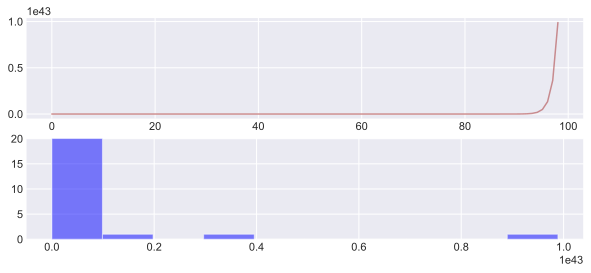

In [41]:
exp_series = [np.exp(i) for i in range(1,100)]

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(exp_series, color = 'brown', alpha = 0.5)
axes[1].hist(exp_series,bins = 10, alpha = 0.5, color = 'blue')

axes[1].set_ylim(0,20)

for i in range(2):
    
    axes[i].grid()


plt.show()

Running the example creates a line plot of the series and a histogram of the distribution of observations. We see an extreme increase on the line graph and an equally extreme long tail distribution on the histogram (not very visible!).

Again, we can transform this series back to linear by taking the natural logarithm of the values. This would make the series linear and the distribution uniform. The example below demonstrates this for completeness.

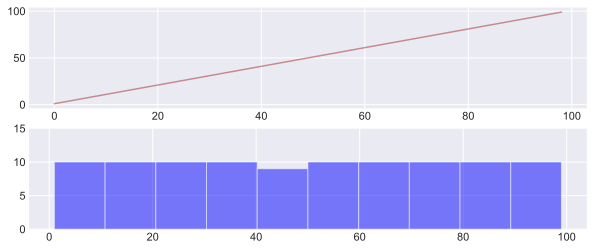

In [42]:
lexp_series = np.log(exp_series)

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(lexp_series, color = 'brown', alpha = 0.5)
axes[1].hist(lexp_series,bins = 10, alpha = 0.5, color = 'blue')

axes[1].set_ylim(0,15)

for i in range(2):
    
    axes[i].grid()


plt.show()

Our Airline Passengers dataset has a distribution of this form, but perhaps not this extreme. The example below demonstrates a log transform of the Airline Passengers dataset.


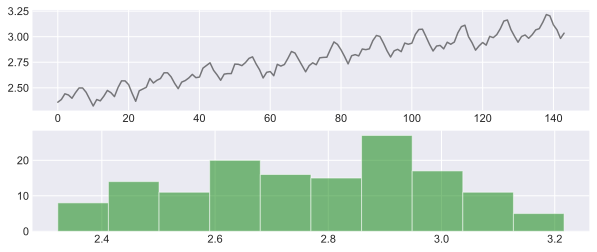

In [43]:
pass_df.passangers = np.log(pass_df['passangers'])

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(pass_df.passangers, color = 'black', alpha = 0.5)
axes[1].hist(pass_df.passangers,bins = 10, alpha = 0.5, color = 'green')

axes[0].grid()
axes[1].grid()
plt.show()

Running the example results in a trend that does look a lot more linear than the square root transform above. The line plot shows a seemingly linear growth and variance. The histogram also shows a more uniform or squashed Gaussian-like distribution of observations.

Log transforms are popular with time series data as they are effective at removing exponential variance. It is important to note that this operation assumes values are positive and non-zero. It is common to transform observations by adding a fixed constant to ensure all input values meet this requirement. For example:

$$ \textrm{transform} = \log(1+x) $$

Where `log` is the natural logarithm, transform is the transformed series, constant is a fixed value that lifts all observations above zero, and `x` is the time series.


### Box-Cox Transform


The square root transform and log transform belong to a class of transforms called power transforms. The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

More than that, it can be configured to evaluate a suite of transforms automatically and select a best fit. It can be thought of as a power tool to iron out power-based change in your time series. The resulting series may be more linear and the resulting distribution more Gaussian or Uniform, depending on the underlying process that generated it. The `scipy.stats` library provides an implementation of the Box-Cox transform. The`boxcox()` function3 takes an argument, called `lambda`, that controls the type of transform to perform. Below are some common values for lambda:

- `lambda` = -1.0 is a reciprocal transform.
- `lambda` = -0.5 is a reciprocal square root transform. 
- `lambda` = 0.0 is a log transform.
- `lambda` = 0.5 is a square root transform.
- `lambda` = 1.0 is no transform.


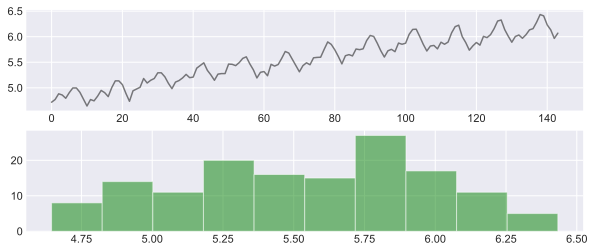

In [44]:
from scipy.stats import boxcox

pass_df = pd.DataFrame(ap_series.values)

pass_df.columns = ['passangers']

pass_df.passangers = boxcox(pass_df['passangers'], lmbda = 0.0)

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(pass_df.passangers, color = 'black', alpha = 0.5)
axes[1].hist(pass_df.passangers,bins = 10, alpha = 0.5, color = 'green')

axes[0].grid()
axes[1].grid()
plt.show()

We can set the lambda parameter to None (the default) and let the function find a statistically tuned value. The following example demonstrates this usage, returning both the transformed dataset and the chosen lambda value.

The optimized value of lambda is: 0.14802265137037945


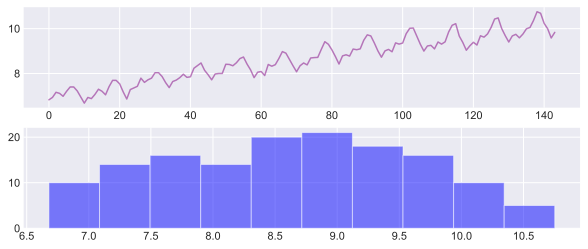

In [45]:
pass_df = pd.DataFrame(ap_series.values)

pass_df.columns = ['passangers']

pass_df.passangers, l = boxcox(pass_df['passangers'])

print(f"The optimized value of lambda is: {l}")

fig, axes = plt.subplots(2,1,figsize = (10,4))

axes[0].plot(pass_df.passangers, color = 'purple', alpha = 0.5)
axes[1].hist(pass_df.passangers,bins = 10, alpha = 0.5, color = 'blue')

axes[0].grid()
axes[1].grid()
plt.show()

Running the example discovers the lambda value of 0.148023. We can see that this is very close to a lambda value of 0.0, resulting in a log transform and stronger (less than) than 0.5 for the square root transform. Therefore the line and histogram plots are also very similar to those from the log transform.

----

## CH9: Moving Average Smoothing

----

Moving average smoothing is a naive and e ective technique in time series forecasting. It can
be used for data preparation, feature engineering, and even directly for making predictions. In
this tutorial, you will discover how to use moving average smoothing for time series forecasting
with Python. After completing this tutorial, you will know:

- How moving average smoothing works and some expectations of your data before you can
use it.
- How to use moving average smoothing for data preparation and feature engineering.
- How to use moving average smoothing to make predictions.

Smoothing is a technique applied to time series to remove the  ne-grained variation between
time steps. The hope of smoothing is to remove noise and better expose the signal of the
underlying causal processes. Moving averages are a simple and common type of smoothing
used in time series analysis and time series forecasting. Calculating a moving average involves
creating a new series where the values are comprised of the average of raw observations in the
original time series.
A moving average requires that you specify a window size called the window width. This
de nes the number of raw observations used to calculate the moving average value. The moving
part in the moving average refers to the fact that the window de ned by the window width is
slid along the time series to calculate the average values in the new series. There are two main
types of moving average that are used: Centered and Trailing Moving Average.

### Centered Moving Average: 

The value at time `(t)` is calculated as the average of raw observations at, before, and after time
`(t)`. For example, a center moving average with a window of 3 would be calculated as:

$$ center_{-}ma(t) = mean(obs(t - 1); obs(t); obs(t + 1))$$

This method requires knowledge of future values, and as such is used on time series analysis
to better understand the dataset. A center moving average can be used as a general method to
remove trend and seasonal components from a time series, a method that we often **cannot** use
when forecasting.

### Trailing Moving Average:

The value at time `(t)` is calculated as the average of the raw observations at and before the
time `(t)`. For example, a trailing moving average with a window of 3 would be calculated as:

$$ trail_{-}ma(t) = mean(obs(t - 2); obs(t - 1); obs(t)) $$

Trailing moving average only uses historical observations and is used on time series forecasting.
It is the type of moving average that we will focus on in this tutorial.

### Data Expectations: 

Calculating a moving average of a time series makes some assumptions about your data. It is
assumed that both trend and seasonal components have been removed from your time series.
This means that your time series is stationary, or does not show obvious trends (long-term
increasing or decreasing movement) or seasonality (consistent periodic structure).
There are many methods to remove trends and seasonality from a time series dataset when
forecasting. Two good methods for each are to use the di erencing method and to model the
behavior and explicitly subtract it from the series.
Moving average values can be used in a number of ways when using machine learning
algorithms on time series problems. In this tutorial, we will look at how we can calculate trailing
moving average values for use as data preparation, feature engineering, and for directly making
predictions. Before we dive into these examples, let's look at the Daily Female Births dataset
that we will use in each example.

In this lesson, we will use the Daily Female Births Dataset as an example. This dataset
describes the number of daily female births in California in 1959.

In [46]:
fb_df = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True)

fb_df.head()

Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44

In [47]:
fb_series = fb_df.squeeze('columns')

fb_series.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

#### Moving Average as Data Preparation: 
Moving average can be used as a data preparation technique to create a smoothed version of
the original dataset. Smoothing is useful as a data preparation technique as it can reduce the
random variation in the observations and better expose the structure of the underlying causal
processes.

The `rolling()` function1 on the Series Pandas object will automatically group observations
into a window. You can specify the window size, and by default a trailing window is created.
Once the window is created, we can take the mean value, and this is our transformed dataset.
New observations in the future can be just as easily transformed by keeping the raw values
for the last few observations and updating a new average value. To make this concrete, with
a window size of 3, the transformed value at time `(t)` is calculated as the mean value for the
previous 3 observations `(t-2, t-1, t)`, as follows:

$$ obs(t) = \frac{1}{3}(obs(t - 2) + obs(t - 1) + obs(t)) $$

Below is an example of transforming the Daily Female Births dataset into a moving average
with a window size of 3 days, chosen arbitrarily.

In [48]:
fb_rolling = fb_series.rolling(window = 3)

fb_rolling_mean = fb_rolling.mean()

fb_rolling_mean.head()

Date
1959-01-01          NaN
1959-01-02          NaN
1959-01-03    32.333333
1959-01-04    31.000000
1959-01-05    35.000000
Name: Births, dtype: float64

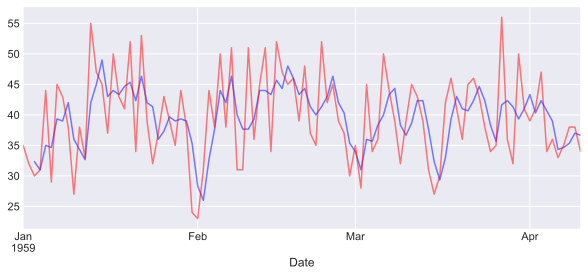

In [49]:
fig, axes = plt.subplots(figsize = (10,4))

fb_rolling_mean[:100].plot(color = 'blue', alpha = 0.5)
fb_series[:100].plot(alpha = 0.5, color = 'red')

plt.grid()
plt.show()

Here, you can clearly see the lag in the transformed dataset. Next, let's take a look at using
the moving average as a feature engineering method.

#### Moving Average as Feature Engineering:

The moving average can be used as a source of new information when modeling a time series
forecast as a supervised learning problem. In this case, the moving average is calculated and
added as a new input feature used to predict the next time step.

- First, a copy of the series must
be shifted forward by one time step. This will represent the input to our prediction problem,
or a `lag=1` version of the series. This is a standard supervised learning view of the time series
problem. 

- Next, a second copy of the series needs to be shifted forward by the window size minus one.
This is to ensure that the moving average summarizes the last few values and does not include
the value to be predicted in the average, which would be an invalid framing of the problem as
the input would contain knowledge of the future being predicted.
For example, with a window size of 3, we must shift the series forward by 2 time steps. This
is because we want to include the previous two observations as well as the current observation
in the moving average in order to predict the next value. We can then calculate the moving
average from this shifted series. Below is an example of how the first 5 moving average values
are calculated. Remember, the dataset is shifted forward 2 time steps and as we move along
the time series, it takes at least 3 time steps before we even have enough data to calculate a
`window=3` moving average.

In [50]:
df = pd.DataFrame(fb_series.values)

width = 3

lag1 = df.shift(1)
lag3 = df.shift(width-1)


In [51]:
window = lag3.rolling(window = width)

means = window.mean()

In [52]:
fdf = pd.concat([means, lag1, df], axis = 1)

fdf.columns = ['mean', 't', 't+1']

fdf.head(10)

mean     t  t+1
0        NaN   NaN   35
1        NaN  35.0   32
2        NaN  32.0   30
3        NaN  30.0   31
4  32.333333  31.0   44
5  31.000000  44.0   29
6  35.000000  29.0   45
7  34.666667  45.0   43
8  39.333333  43.0   38
9  39.000000  38.0   27

Running the example creates the new dataset and prints the first 10 rows. We can see that
the  first 3 rows cannot be used and must be discarded. The first row of the `lag=1` dataset cannot
be used because there are no previous observations to predict the first observation, therefore a
`NaN` value is used.

#### Moving Average as Prediction:

The moving average value can also be used directly to make predictions. It is a naive model
and assumes that the trend and seasonality components of the time series have already been
removed or adjusted for. The moving average model for predictions can easily be used in a
walk-forward manner. As new observations are made available (e.g. daily), the model can be
updated and a prediction made for the next day. We can implement this manually in Python.
Below is an example of the moving average model used in a walk-forward manner.

In [57]:
# moving average smoothing as a forecast model
from sklearn.metrics import mean_squared_error
import numpy as np

# prepare situation
X = fb_series.values # all values in the series

window = 3

history = [X[i] for i in range(window)] # initial histor of first 3 values in the series 
test = [X[i] for i in range(window, len(X))] # the rest of the values in the series
predictions = list()



In [58]:
# walk forward over time steps in test
for t in range(len(test)):
    
    length = len(history) # length of the history is updated, starts with 3 and it is updated by +1 at each time increment t
    
    yhat = np.mean([history[i] for i in range(length-window,length)]) # in the first iteration it takes the first 3 vals in the history and takes the mean
                                                                      # it then slides the window as the length of the history changes  
    predictions.append(yhat) # append to the empty predictions list 

    obs = test[t]   
    history.append(obs) #update the history by one observation at a time t in test series 
    
    print(f'predicted={yhat:.2f}, expected={obs:.2f}')

predicted=32.33, expected=31.00
predicted=31.00, expected=44.00
predicted=35.00, expected=29.00
predicted=34.67, expected=45.00
predicted=39.33, expected=43.00
predicted=39.00, expected=38.00
predicted=42.00, expected=27.00
predicted=36.00, expected=38.00
predicted=34.33, expected=33.00
predicted=32.67, expected=55.00
predicted=42.00, expected=47.00
predicted=45.00, expected=45.00
predicted=49.00, expected=37.00
predicted=43.00, expected=50.00
predicted=44.00, expected=43.00
predicted=43.33, expected=41.00
predicted=44.67, expected=52.00
predicted=45.33, expected=34.00
predicted=42.33, expected=53.00
predicted=46.33, expected=39.00
predicted=42.00, expected=32.00
predicted=41.33, expected=37.00
predicted=36.00, expected=43.00
predicted=37.33, expected=39.00
predicted=39.67, expected=35.00
predicted=39.00, expected=44.00
predicted=39.33, expected=38.00
predicted=39.00, expected=24.00
predicted=35.33, expected=23.00
predicted=28.33, expected=31.00
predicted=26.00, expected=44.00
predicte

In [59]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE:{rmse:.3f}')

Test RMSE:7.834


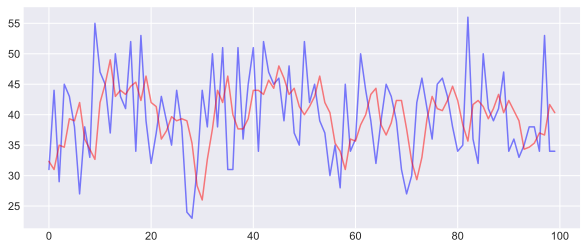

In [60]:
# zoomed plot of first 100 test and predictions 
fig, axes = plt.subplots(figsize = (10,4))

plt.plot(test[:100],color = 'blue', alpha = 0.5)
plt.plot(predictions[:100], alpha = 0.5, color = 'red')

plt.grid()
plt.show()